In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("../data/one-hot矩阵.xls", encoding='gbk')
print(df.shape)
df.head()

(104, 17)


,头痛,头晕,胶质瘤手术,意识障碍,肢体无力,肢体活动不灵,呕吐,肢体抽搐,恶心,占位性病变,言语障碍,肢体麻木,视物模糊,记忆力减退,行走不稳,大小便失禁,生存期
0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,11.5
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,11.0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,12.0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12.0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,14.0


# Feature Selection

In [3]:
# replace Chinese column names with numbers for better display
cols = {col:i for i, col in enumerate(df.columns)}
print(cols)

# inverse the column-number mapping for later use
rev_cols = {v:k for k,v in cols.items()}
print(rev_cols)

{'头痛': 0, '头晕': 1, '胶质瘤手术': 2, '意识障碍': 3, '肢体无力': 4, '肢体活动不灵': 5, '呕吐': 6, '肢体抽搐': 7, '恶心': 8, '占位性病变': 9, '言语障碍': 10, '肢体麻木': 11, '视物模糊': 12, '记忆力减退': 13, '行走不稳': 14, '大小便失禁': 15, '生存期': 16}
{0: '头痛', 1: '头晕', 2: '胶质瘤手术', 3: '意识障碍', 4: '肢体无力', 5: '肢体活动不灵', 6: '呕吐', 7: '肢体抽搐', 8: '恶心', 9: '占位性病变', 10: '言语障碍', 11: '肢体麻木', 12: '视物模糊', 13: '记忆力减退', 14: '行走不稳', 15: '大小便失禁', 16: '生存期'}


In [4]:
# rename the dataframe columns with numbers
df1 = df.rename(columns=cols)

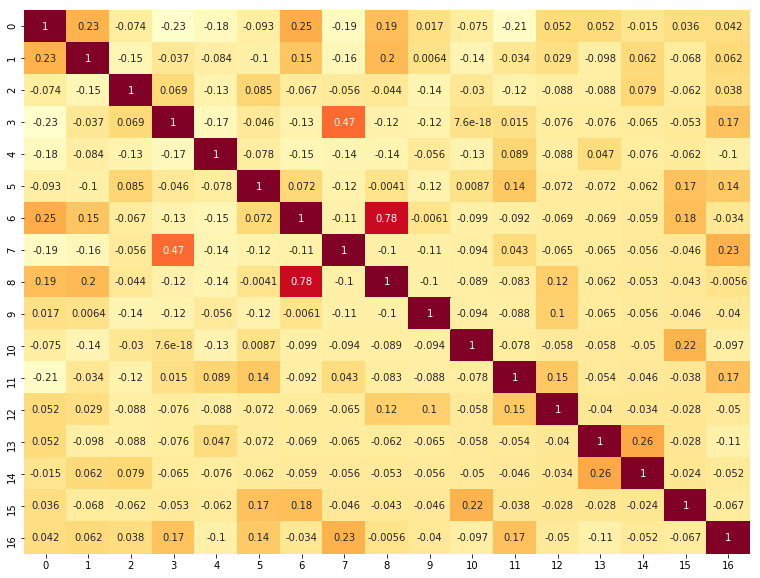

In [5]:
plt.figure(figsize=(13,10))
corr = df1.corr()
sns.heatmap(corr, annot=True, cbar=False, cmap='YlOrRd')

we see that column 3 and 7 are highlycorrelated and that 6 and 8 are highly correlated.

In [6]:
# print out the highly correlated features
print(f"({rev_cols[3]}, {rev_cols[7]})")
print(f"({rev_cols[6]}, {rev_cols[8]})")

(意识障碍, 肢体抽搐)
(呕吐, 恶心)


In [7]:
# we leave the features that are more correlated with the class variable
print(f"Corr of feature 3 with class: {corr.iloc[3, 16]}")
print(f"Corr of feature 7 with class: {corr.iloc[7, 16]}")
print()
print(f"Corr of feature 6 with class: {corr.iloc[6, 16]}")
print(f"Corr of feature 8 with class: {corr.iloc[8, 16]}")

if abs(corr.iloc[3, 16]) > abs(corr.iloc[7, 16]):
    df1.drop(columns=7, inplace=True)
    df.drop(columns=rev_cols[7], inplace=True)
else:
    df1.drop(columns=3, inplace=True)
    df.drop(columns=rev_cols[3], inplace=True)
    
if abs(corr.iloc[6, 16]) > abs(corr.iloc[8, 16]):
    df1.drop(columns=8, inplace=True)
    df.drop(columns=rev_cols[8], inplace=True)
else:
    df1.drop(columns=6, inplace=True)
    df.drop(columns=rev_cols[6], inplace=True)

df.head()

Corr of feature 3 with class: 0.16517924036624818
Corr of feature 7 with class: 0.23398724305019988

Corr of feature 6 with class: -0.03396177726551853
Corr of feature 8 with class: -0.005612413535559225


,头痛,头晕,胶质瘤手术,肢体无力,肢体活动不灵,呕吐,肢体抽搐,占位性病变,言语障碍,肢体麻木,视物模糊,记忆力减退,行走不稳,大小便失禁,生存期
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,11.5
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,11.0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,12.0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,12.0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,14.0


# Model Building

In [8]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import Lasso, Ridge

In [9]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

kf = KFold(n_splits=4, random_state=42, shuffle=True)
scores = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], \
        y.iloc[train_index], y.iloc[test_index]
    
    ls_params = {'alpha':(.1, .25, .5, .75, 1.),
                 'max_iter':(100, 1000, 2000, 5000),
                 'tol':(.00001, .0001, .001, .01, .1)}
    gs = GridSearchCV(Lasso(),
                      ls_params,
                      scoring='explained_variance',
                      cv=4,
                      iid=False,
                      n_jobs=-1)
    
    gs.fit(X_train, y_train.values.ravel())
    print(gs.best_params_)
    print('Lasso:', gs.score(X_test, y_test))
    print()

{'alpha': 1.0, 'max_iter': 100, 'tol': 0.1}
Lasso: 0.017404914428865048

{'alpha': 1.0, 'max_iter': 100, 'tol': 0.1}
Lasso: -0.03579648936161983

{'alpha': 1.0, 'max_iter': 100, 'tol': 0.0001}
Lasso: -0.002260603091698732

{'alpha': 1.0, 'max_iter': 100, 'tol': 0.1}
Lasso: 0.0

